In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Requirements

In [2]:
!pip install pip --upgrade 
!pip install -U scikit-learn
!pip install mlxtend --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 49.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.0 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlx

In [3]:
!pip install arabic-reshaper
!pip install python-bidi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [4]:
import time
import joblib

import numpy as np
import pandas as pd
import plotly.express as px 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.ensemble import VotingClassifier
# from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import LearningCurveDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, StratifiedShuffleSplit

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

from bidi.algorithm import get_display
from arabic_reshaper import reshape

## Essential functions and preprocessing 

### Metrics, ROC curve, Learning curve

In [5]:
def showMetrics(model, fset, xTrain, yTrain, xTest, yTest):

  print("Train Data on {} features \n".format(fset))  
  print(classification_report(yTrain, model.predict(xTrain)))
  print()
  print("Test Data on {} features \n".format(fset))
  print(classification_report(yTest, model.predict(xTest)))
  
  filename = f"{model.__class__.__name__}_{fset}.joblib"
  joblib.dump(model, filename)

In [6]:
colors = [c[4:] for c in list(mcolors.TABLEAU_COLORS)]

In [7]:
def plotRocCurve(yTest, yPred, nClasses):
  classes = np.arange(nClasses)
  
  yTrue = label_binarize(yTest, classes=classes)
  yScore = label_binarize(yPred, classes=classes)
  
  fpr, tpr, roc_auc = dict(), dict(), dict()

  for i in range(nClasses):
      fpr[i], tpr[i], _ =  roc_curve(yTrue[:, i], yScore[:, i])
      roc_auc[i] =  auc(fpr[i], tpr[i])

  plt.figure()

  for i in range(nClasses):    
    temp_label = 'ROC of class {0} (area={1:0.2f})'.format(i, roc_auc[i])
    plt.plot(fpr[i], tpr[i], label=temp_label, color=colors[i])

    plt.plot([0, 1], [0, 1], linestyle='--', color='black')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
        
  plt.show()

In [8]:
def plotLearningCurve(estimator):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)
  
  common_params = {
      "X": xNormal,
      "y": pd.concat([yTrain, yTest]),
      "train_sizes": np.linspace(0.1, 1.0, 5),
      "cv": StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=0),
      "score_type": "both",
      "n_jobs": -1,
      "line_kw": {"marker": "o"},
      "std_display_style": "fill_between",
      "score_name": "Accuracy",
  }

  LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
  handles, label = ax.get_legend_handles_labels()
  ax.legend(handles[:2], ["Training Score", "Test Score"])
  ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

### Loading data

In [9]:
train = pd.read_csv("/content/drive/MyDrive/MSC/MachineLearning/Project/freqFeaturesTrain.csv")
test = pd.read_csv("/content/drive/MyDrive/MSC/MachineLearning/Project/freqFeaturesTest.csv")

xTrain = train.iloc[:, :82]
yTrain = train.iloc[:, -1]
xTest = test.iloc[:, :82]
yTest = test.iloc[:, -1]

X = pd.concat([xTrain, xTest])
scaler = StandardScaler()
xNormal = scaler.fit_transform(X)
xTrain = scaler.transform(xTrain)
xTest = scaler.transform(xTest)

## Distribution of target values in test and train data

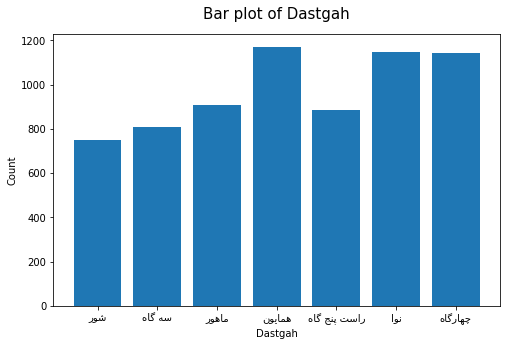

In [19]:
labels = ['شور', 'سه گاه', 'ماهور', 'همایون', 'راست پنج گاه', 'نوا', 'چهارگاه']
persian_labels = [get_display(reshape(label)) for label in labels]

plt.figure(figsize= (8, 5))  

value_counts = yTrain.value_counts().sort_index() 
x_pos = np.arange(0, len(value_counts))

plt.bar(x_pos, value_counts.values, tick_label = persian_labels)
plt.title("Bar plot of Dastgah", fontsize=15, pad=15)
plt.xlabel("Dastgah")
plt.ylabel("Count")

plt.show()

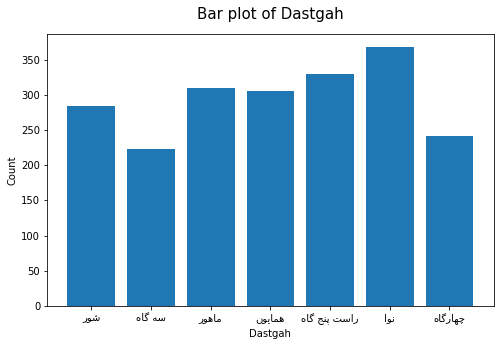

In [20]:
plt.figure(figsize= (8, 5))  

value_counts = yTest.value_counts().sort_index() 
x_pos = np.arange(0, len(value_counts))

plt.bar(x_pos, value_counts.values, tick_label = persian_labels)
plt.title("Bar plot of Dastgah", fontsize=15, pad=15)
plt.xlabel("Dastgah")
plt.ylabel("Count")

plt.show()

## Dimension Reduction Methods

### PCA

In [23]:
pca = PCA(n_components=2) 
components = pca.fit_transform(xNormal) 
fig = px.scatter(components, x=0, y=1, color=pd.concat([yTrain, yTest])) 
fig.show()

In [24]:
pca = PCA() 
pca.fit(xNormal)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_) 

fig = px.line( x=range(1, exp_var_cumul.shape[0] + 1), y=exp_var_cumul, labels={"x": "# Components", "y": "Explained Variance"} )
fig.add_hline(y = 0.95,
                annotation_text='95% cut-off threshold',
                annotation_position="top left",
                line=dict(color='Red',),    
)

In [25]:
pca = PCA(n_components=52) 

components_train = pca.fit_transform(xTrain) 
X_train_pca = pd.DataFrame(components_train)

components_test = pca.fit_transform(xTest) 
X_test_pca = pd.DataFrame(components_test)

### LDA

In [26]:
model_1 = LinearDiscriminantAnalysis()
X_train_lda = model_1.fit(xTrain, yTrain).transform(xTrain)

model_2 = LinearDiscriminantAnalysis()
X_test_lda = model_2.fit(xTest, yTest).transform(xTest)

### Forward Selection

In [27]:
def forwardSelection(model, X, y):
  sfs = SFS(model, 
            k_features=20, 
            forward=True, 
            floating=False, 
            verbose=2,
            scoring='accuracy',
            n_jobs=-1,
            cv=0)

  sfs = sfs.fit(X, y)
  return list(sfs.k_feature_names_)

### Backward Elimination

In [28]:
def backwardElimination(model, X, y):
  sfs = SFS(model, 
            k_features=72, 
            forward=False, 
            verbose=1, 
            n_jobs=-1,
            scoring='neg_mean_squared_error')
  sfs = sfs.fit(X, y)
  return list(sfs.k_feature_names_)

## Classification

In [10]:
nClasses =len (yTrain.unique())

### XGBoost

In [11]:
xgbModel = XGBClassifier(objective="multi:softprob", random_state=42)

init_time = time.time()
xgbModel.fit(xTrain, yTrain)
print("Model calculation time:",  
      (time.time() - init_time)*1000, 
      "miliseconds\n")

showMetrics(xgbModel, "frequency", xTrain, yTrain, xTest, yTest)

Model calculation time: 70594.26689147949 miliseconds

Train Data on frequency features 

              precision    recall  f1-score   support

           0       0.89      0.77      0.82       752
           1       0.89      0.83      0.86       810
           2       0.78      0.82      0.80       909
           3       0.79      0.84      0.82      1170
           4       0.86      0.75      0.80       885
           5       0.81      0.84      0.83      1146
           6       0.81      0.88      0.85      1142

    accuracy                           0.82      6814
   macro avg       0.83      0.82      0.82      6814
weighted avg       0.83      0.82      0.82      6814


Test Data on frequency features 

              precision    recall  f1-score   support

           0       0.38      0.17      0.24       284
           1       0.34      0.27      0.30       223
           2       0.34      0.39      0.36       310
           3       0.29      0.49      0.36       306
       

### KNN

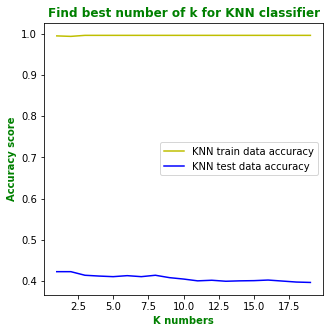

In [30]:
train_knn_accuracy = list()
test_knn_accuracy = list()

for i in range(1, 20):
    temp_KNN = KNeighborsClassifier(n_neighbors=i, weights='distance', metric='manhattan', algorithm='ball_tree')
    temp_KNN.fit(xTrain, yTrain)
    train_knn_accuracy.append(temp_KNN.score(xTrain, yTrain))
    test_knn_accuracy.append(temp_KNN.score(xTest, yTest))
    
plt.figure(figsize = (5, 5)) 
plt.plot([int(i) for i in range(1, 20)], train_knn_accuracy, color="y", label="KNN train data accuracy")
plt.plot([int(i) for i in range(1, 20)], test_knn_accuracy, color="b", label="KNN test data accuracy")

plt.title("Find best number of k for KNN classifier", color = 'green', fontweight = 'bold') 
plt.xlabel("K numbers", color = 'green', fontweight = 'bold') 
plt.ylabel("Accuracy score", color = 'green', fontweight = 'bold')

plt.legend(loc="best")
plt.show()

In [12]:
knn = KNeighborsClassifier(n_neighbors=2, weights='distance', metric='manhattan', algorithm='ball_tree')

init_time = time.time()
knn.fit(xTrain, yTrain)
print("Model calculation time:",  
      (time.time() - init_time)*1000, 
      "miliseconds\n")

showMetrics(knn, "frequency", xTrain, yTrain, xTest, yTest)

Model calculation time: 49.013376235961914 miliseconds

Train Data on frequency features 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       752
           1       1.00      1.00      1.00       810
           2       1.00      1.00      1.00       909
           3       1.00      1.00      1.00      1170
           4       0.96      1.00      0.98       885
           5       1.00      0.97      0.98      1146
           6       1.00      1.00      1.00      1142

    accuracy                           0.99      6814
   macro avg       0.99      0.99      0.99      6814
weighted avg       0.99      0.99      0.99      6814


Test Data on frequency features 

              precision    recall  f1-score   support

           0       0.45      0.43      0.44       284
           1       0.47      0.54      0.50       223
           2       0.36      0.39      0.37       310
           3       0.44      0.44      0.44       306
      

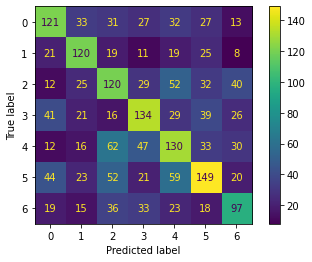

In [32]:
preds = knn.predict(xTest).round()
cm = confusion_matrix(yTest, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

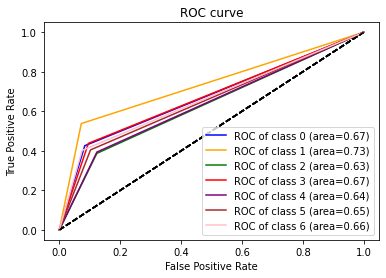

In [33]:
plotRocCurve(yTest, knn.predict(xTest), nClasses)

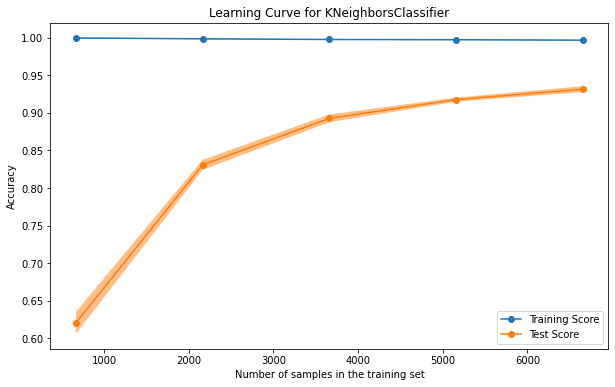

In [34]:
plotLearningCurve(knn)

#### Apply Dimension Reduction Data on KNN

Model calculation time: 44.50345039367676 miliseconds

Train Data on frequency features 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       752
           1       1.00      1.00      1.00       810
           2       1.00      1.00      1.00       909
           3       1.00      1.00      1.00      1170
           4       1.00      1.00      1.00       885
           5       1.00      1.00      1.00      1146
           6       1.00      1.00      1.00      1142

    accuracy                           1.00      6814
   macro avg       1.00      1.00      1.00      6814
weighted avg       1.00      1.00      1.00      6814


Test Data on frequency features 

              precision    recall  f1-score   support

           0       0.17      0.13      0.15       284
           1       0.11      0.13      0.12       223
           2       0.18      0.17      0.18       310
           3       0.19      0.19      0.19       306
       

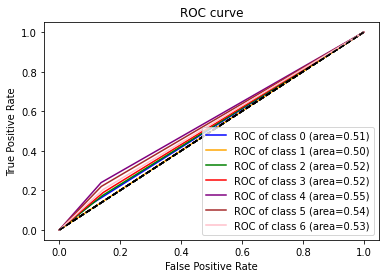

In [39]:
knn_pca = KNeighborsClassifier(n_neighbors=2, weights='distance', metric='manhattan', algorithm='ball_tree')
init_time = time.time()
knn_pca.fit(X_train_pca, yTrain)
print("Model calculation time:",  
      (time.time() - init_time)*1000, 
      "miliseconds\n")

showMetrics(knn_pca, "frequency", X_train_pca, yTrain, X_test_pca, yTest)
plotRocCurve(yTest, knn_pca.predict(X_test_pca), nClasses)

Model calculation time: 6.068706512451172 miliseconds

Train Data on frequency features 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       752
           1       1.00      1.00      1.00       810
           2       1.00      1.00      1.00       909
           3       1.00      1.00      1.00      1170
           4       1.00      1.00      1.00       885
           5       1.00      1.00      1.00      1146
           6       1.00      1.00      1.00      1142

    accuracy                           1.00      6814
   macro avg       1.00      1.00      1.00      6814
weighted avg       1.00      1.00      1.00      6814


Test Data on frequency features 



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.56      1.00      0.72       284
           1       0.00      0.00      0.00       223
           2       0.00      0.00      0.00       310
           3       1.00      1.00      1.00       306
           4       0.00      0.00      0.00       330
           5       0.00      0.00      0.00       368
           6       0.40      1.00      0.57       241

    accuracy                           0.40      2062
   macro avg       0.28      0.43      0.33      2062
weighted avg       0.27      0.40      0.31      2062



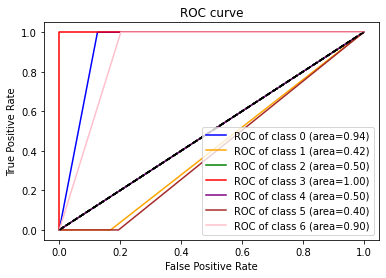

In [40]:
knn_lda = KNeighborsClassifier(n_neighbors=2, weights='distance', metric='manhattan', algorithm='ball_tree')
init_time = time.time()
knn_lda.fit(X_train_lda, yTrain)
print("Model calculation time:",  
      (time.time() - init_time)*1000, 
      "miliseconds\n")

showMetrics(knn_lda, "frequency", X_train_lda, yTrain, X_test_lda, yTest)
plotRocCurve(yTest, knn_lda.predict(X_test_lda), nClasses)

In [41]:
knn_fs = KNeighborsClassifier(n_neighbors=2, weights='distance', metric='manhattan', algorithm='ball_tree')
features_fs = forwardSelection(knn_fs, xTrain, yTrain)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:    2.8s finished

[2023-02-13 07:34:04] Features: 1/20 -- score: 1.0[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    4.6s finished

[2023-02-13 07:34:08] Features: 2/20 -- score: 1.0[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  78 out of  81 | elapsed:    8.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    8.3s finished

[2023-02-13 07:34:17] Features: 3/20 -- score: 1.0[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   15.5s f

In [42]:
features_fs = list(map(int, features_fs))
features_fs

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 82]

Model calculation time: 19.683361053466797 miliseconds

Train Data on frequency features 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       752
           1       1.00      1.00      1.00       810
           2       1.00      1.00      1.00       909
           3       1.00      1.00      1.00      1170
           4       1.00      1.00      1.00       885
           5       1.00      1.00      1.00      1146
           6       1.00      1.00      1.00      1142

    accuracy                           1.00      6814
   macro avg       1.00      1.00      1.00      6814
weighted avg       1.00      1.00      1.00      6814


Test Data on frequency features 

              precision    recall  f1-score   support

           0       0.79      0.61      0.69       284
           1       0.56      0.64      0.59       223
           2       0.55      0.60      0.58       310
           3       0.51      0.55      0.53       306
      

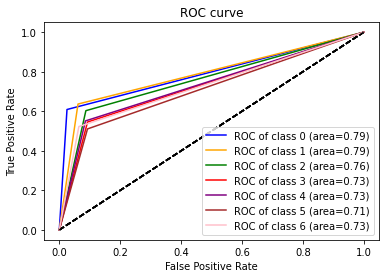

In [43]:
X_train_fs = xTrain[:,features_fs]
X_test_fs = xTest[:, features_fs]

knn_fs = KNeighborsClassifier(n_neighbors=2, weights='distance', metric='manhattan', algorithm='ball_tree')
init_time = time.time()
knn_fs.fit(X_train_fs, yTrain)
print("Model calculation time:",  
      (time.time() - init_time)*1000, 
      "miliseconds\n")

showMetrics(knn_fs, "frequency", X_train_fs, yTrain, X_test_fs, yTest)
plotRocCurve(yTest, knn_fs.predict(X_test_fs), nClasses)

In [44]:
knn_be = KNeighborsClassifier(n_neighbors=2, weights='distance', metric='manhattan', algorithm='ball_tree')
features = backwardElimination(knn_be, xTrain, yTrain)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:  8.1min finished
Features: 82/72[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  7.9min finished
Features: 81/72[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  7.5min finished
Features: 80/72[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  7.2min finished
Features: 79/72[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 

In [45]:
features_be = list(map(int, features))
features_be

[0,
 1,
 2,
 4,
 5,
 6,
 7,
 9,
 10,
 11,
 12,
 13,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 36,
 37,
 38,
 39,
 40,
 41,
 43,
 44,
 46,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 79,
 80,
 82]

Model calculation time: 45.337677001953125 miliseconds

Train Data on frequency features 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       752
           1       1.00      1.00      1.00       810
           2       1.00      1.00      1.00       909
           3       1.00      1.00      1.00      1170
           4       1.00      1.00      1.00       885
           5       1.00      1.00      1.00      1146
           6       1.00      1.00      1.00      1142

    accuracy                           1.00      6814
   macro avg       1.00      1.00      1.00      6814
weighted avg       1.00      1.00      1.00      6814


Test Data on frequency features 

              precision    recall  f1-score   support

           0       0.56      0.48      0.52       284
           1       0.51      0.59      0.54       223
           2       0.42      0.43      0.43       310
           3       0.51      0.49      0.50       306
      

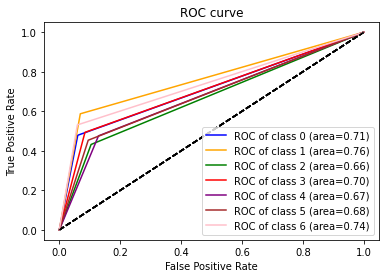

In [46]:
X_train_be = xTrain[:,features_be]
X_test_be = xTest[:, features_be]

knn_be = KNeighborsClassifier(n_neighbors=2, weights='distance', metric='manhattan', algorithm='ball_tree')
init_time = time.time()
knn_be.fit(X_train_be, yTrain)
print("Model calculation time:",  
      (time.time() - init_time)*1000, 
      "miliseconds\n")

showMetrics(knn_be, "frequency", X_train_be, yTrain, X_test_be, yTest)
plotRocCurve(yTest, knn_be.predict(X_test_be), nClasses)

### Logistic Regression

In [13]:
lr = LogisticRegression()

init_time = time.time()
lr.fit(xTrain, yTrain)
print("Model calculation time:",  
      (time.time() - init_time)*1000, 
      "miliseconds\n")

showMetrics(lr, "frequency", xTrain, yTrain, xTest, yTest)

Model calculation time: 1139.36185836792 miliseconds

Train Data on frequency features 

              precision    recall  f1-score   support

           0       0.47      0.43      0.45       752
           1       0.52      0.54      0.53       810
           2       0.48      0.49      0.48       909
           3       0.48      0.48      0.48      1170
           4       0.49      0.42      0.45       885
           5       0.58      0.60      0.59      1146
           6       0.54      0.58      0.56      1142

    accuracy                           0.51      6814
   macro avg       0.51      0.50      0.51      6814
weighted avg       0.51      0.51      0.51      6814


Test Data on frequency features 

              precision    recall  f1-score   support

           0       0.27      0.19      0.22       284
           1       0.16      0.17      0.17       223
           2       0.25      0.25      0.25       310
           3       0.24      0.33      0.28       306
        

### Ensemble Learning

In [14]:
# initializing all the model objects with default parameters
model1 = xgbModel
model2 = knn
model3 = lr
# Making the final model using voting classifier
ensModel = VotingClassifier(
    estimators=[('xgb', model1), ('knn', model2), ('lr', model3)], voting='hard')

init_time = time.time()
ensModel.fit(xTrain, yTrain)
print("Model calculation time:",  
      (time.time() - init_time)*1000, 
      "miliseconds\n")

showMetrics(ensModel, "frequency", xTrain, yTrain, xTest, yTest)

Model calculation time: 31728.272438049316 miliseconds

Train Data on frequency features 

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       752
           1       0.88      0.94      0.91       810
           2       0.82      0.89      0.86       909
           3       0.87      0.88      0.87      1170
           4       0.92      0.80      0.86       885
           5       0.92      0.87      0.89      1146
           6       0.91      0.90      0.91      1142

    accuracy                           0.88      6814
   macro avg       0.88      0.88      0.88      6814
weighted avg       0.88      0.88      0.88      6814


Test Data on frequency features 

              precision    recall  f1-score   support

           0       0.32      0.37      0.34       284
           1       0.31      0.43      0.36       223
           2       0.32      0.40      0.36       310
           3       0.32      0.43      0.36       306
      